In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df =pd.read_csv("/content/cleaned_taxi_data.csv")

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pickup_community_area   15002 non-null  int64  
 1   fare                    15002 non-null  float64
 2   trip_start_month        15002 non-null  int64  
 3   trip_start_hour         15002 non-null  int64  
 4   trip_start_day          15002 non-null  int64  
 5   trip_start_timestamp    15002 non-null  object 
 6   pickup_latitude         15002 non-null  float64
 7   pickup_longitude        15002 non-null  float64
 8   dropoff_latitude        15002 non-null  float64
 9   dropoff_longitude       15002 non-null  float64
 10  trip_miles              15002 non-null  float64
 11  pickup_census_tract     15002 non-null  float64
 12  dropoff_census_tract    15002 non-null  float64
 13  payment_type            15002 non-null  object 
 14  company                 15002 non-null

# 4.a Outliers in Fare and Tips

## (a) Use box plots to identify outliers in fare and tip values

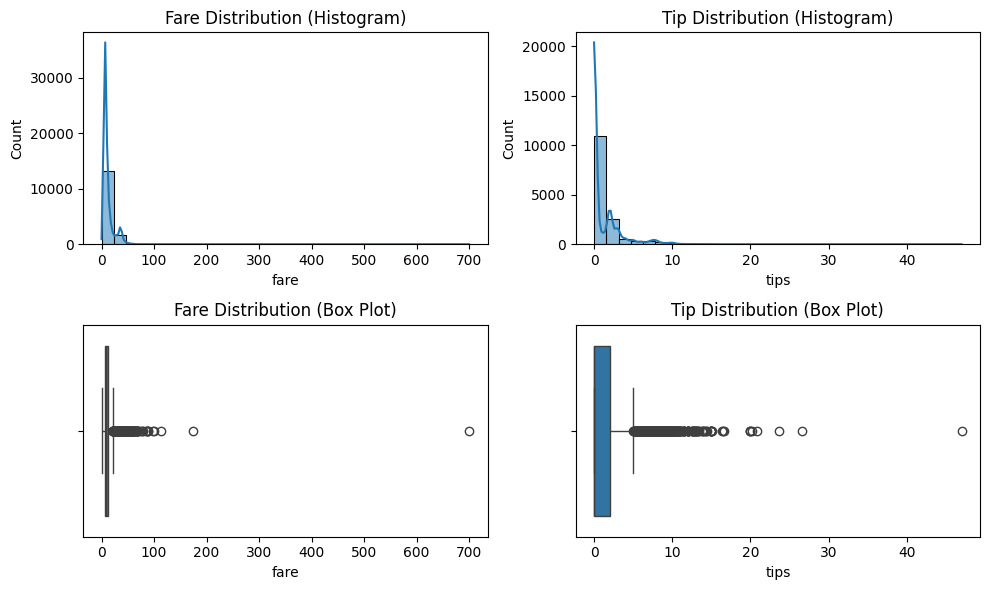

In [126]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Histograms for fare and tips
sns.histplot(df['fare'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Fare Distribution (Histogram)")
sns.histplot(df['tips'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Tip Distribution (Histogram)")

# Box plots for fare and tips
sns.boxplot(x=df['fare'], ax=axes[1, 0])
axes[1, 0].set_title("Fare Distribution (Box Plot)")
sns.boxplot(x=df['tips'], ax=axes[1, 1])
axes[1, 1].set_title("Tip Distribution (Box Plot)")

plt.tight_layout()
plt.show()

## (b) Interpretation: Discuss how these outliers might skew average calculations

In [127]:
# Detecting outliers based on the provided conditions

# Condition 1: Tips are greater than 50% of fare
condition_1 = df['tips'] > 0.5 * df['fare']

# Condition 2: Tips are greater than the 95th percentile (quantile 0.95) of tips
tips_95_quantile = df['tips'].quantile(0.95)
condition_2 = df['tips'] > tips_95_quantile

# Condition 3: Fare is greater than the 95th percentile (quantile 0.95) of fare
fare_95_quantile = df['fare'].quantile(0.95)
condition_3 = df['fare'] > fare_95_quantile

# Applying conditions and counting rows with outliers for each condition
outliers_condition_1 = df[condition_1]
outliers_condition_2 = df[condition_2]
outliers_condition_3 = df[condition_3]

# Display the number of rows satisfying each condition
outlier_counts = {
    "Condition 1 (Tips > 50% of Fare)": len(outliers_condition_1),
    "Condition 2 (Tips > 95th Quantile of Tips)": len(outliers_condition_2),
    "Condition 3 (Fare > 95th Quantile of Fare)": len(outliers_condition_3)
}

outlier_counts


{'Condition 1 (Tips > 50% of Fare)': 230,
 'Condition 2 (Tips > 95th Quantile of Tips)': 749,
 'Condition 3 (Fare > 95th Quantile of Fare)': 730}

In [128]:
# Removing rows that satisfy any of the outlier conditions

# Exclude rows based on each condition
df_cleaned = df[~condition_1 & ~condition_2 & ~condition_3]

# Display the number of rows after removing outliers
df_cleaned.shape


(13638, 18)

## (c) Suggest methods for handling these outliers in predictive models (e.g., removal or adjustment)

1. **Condition 1: Tips > 50% of Fare**
   - **Action**: Cap tips to 50% of the fare for any instance that exceeds this.
   - **Reasoning**: This helps reduce the skew from unusually high tips relative to fares while still keeping some level of generosity in the data.

2. **Condition 2: Tips > 95th Quantile of Tips**
   - **Action**: Cap tips at the 95th percentile value.
   - **Reasoning**: Since these tips represent rare behaviors (top 5%), capping them at the 95th percentile allows the model to generalize better to typical tipping behaviors.

3. **Condition 3: Fare > 95th Quantile of Fare**
   - **Action**: Cap fares at the 95th percentile value.
   - **Reasoning**: Very high fares could result from unusual circumstances or atypical routes. Capping at the 95th percentile keeps the model focused on the general fare patterns while still acknowledging that some fares are higher.

---

**Summary**: By capping these outliers, we control the influence of extreme values without removing any data points entirely. This approach maintains the integrity of the data while helping the model generalize better, as it won’t be overly influenced by rare, extreme cases.

# 4.b Predicting Fare

In [129]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## (a) Implement a regression model using distance, trip duration, and location as predictors to estimate fares

RMSE for Linear Regression: 4.92241363893551


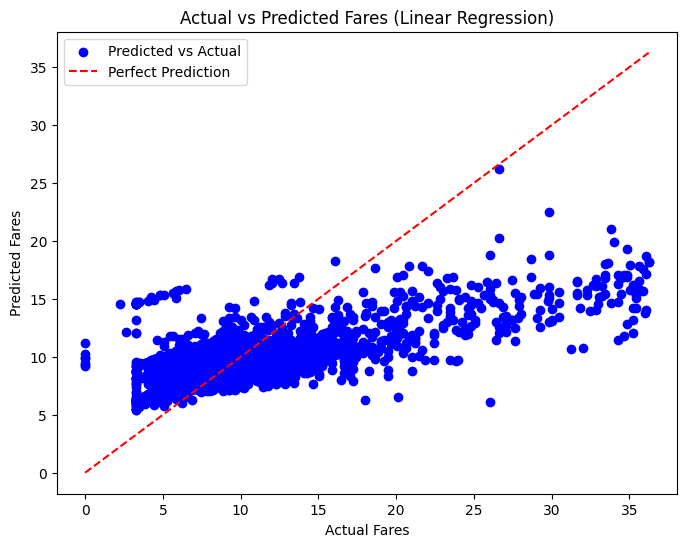

In [130]:
#-------------------------------------------------------------------------------------------------------
# Step 1: Data Preprocessing - Splitting into Train and Test Sets
def preprocess_data(df):

    predictors = ['trip_miles', 'trip_seconds','pickup_community_area','dropoff_community_area']
    target = 'fare'

    X = df[predictors]
    y = df[target]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    return X_train, X_test, y_train, y_test
#-------------------------------------------------------------------------------------------------------

# Step 2: Linear Regression Model - Training and Prediction
def train_linear_regression(X_train, y_train):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    return lr_model

def predict_and_evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Calculate RMSE for Linear Regression
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return y_pred, rmse

#-------------------------------------------------------------------------------------------------------
# Step 3: Visualization of Predictions vs Actual Values
def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')

    # Line for perfect prediction (y = x)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel("Actual Fares")
    plt.ylabel("Predicted Fares")
    plt.title("Actual vs Predicted Fares (Linear Regression)")
    plt.legend()
    plt.show()
#-------------------------------------------------------------------------------------------------------

# Main Execution
X_train, X_test, y_train, y_test = preprocess_data(df_cleaned)
lr_model = train_linear_regression(X_train, y_train)
y_pred_lr, rmse_lr = predict_and_evaluate(lr_model, X_test, y_test)
print(f"RMSE for Linear Regression: {rmse_lr}")
plot_predictions(y_test, y_pred_lr)


RMSE for Random Forest Regressor: 1.7540019303656695


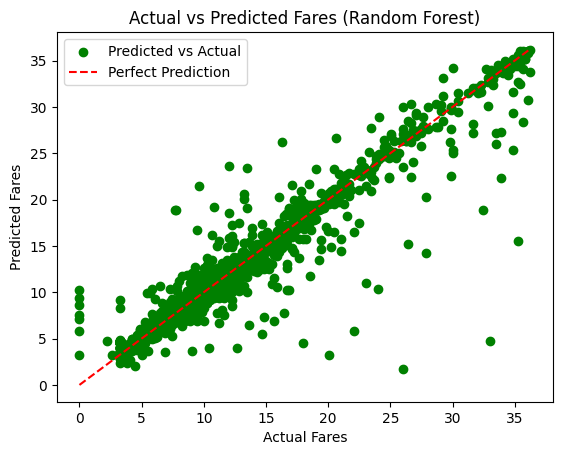

In [131]:
# Step 2: Random Forest Model - Training and Prediction
def train_random_forest(X_train, y_train, n_estimators=100, random_state=42):
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)
    return rf_model

def predict_and_evaluate_rf(model, X_test, y_test):
    y_pred_rf = model.predict(X_test)

    # Calculate RMSE for Random Forest Regressor
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    return y_pred_rf, rmse_rf

# Step 3: Visualization of Predictions vs Actual Values
def plot_rf_predictions(y_test, y_pred_rf):
    plt.scatter(y_test, y_pred_rf, color='green', label='Predicted vs Actual')
    # Line for perfect prediction (y = x)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel("Actual Fares")
    plt.ylabel("Predicted Fares")
    plt.title("Actual vs Predicted Fares (Random Forest)")
    plt.legend()
    plt.show()

# Main Execution
rf_model = train_random_forest(X_train, y_train)
y_pred_rf, rmse_rf = predict_and_evaluate_rf(rf_model, X_test, y_test)
print(f"RMSE for Random Forest Regressor: {rmse_rf}")
plot_rf_predictions(y_test, y_pred_rf)

## (b) Model Evaluation: Present metrics such as RMSE to assess model accuracy

#### RMSE for Linear Regression: 4.92241363893551

#### RMSE for Random Forest Regressor: 1.7540019303656695

## (c) Discussion on Model Effectiveness and Potential Limitations

Upon analyzing the dataset, we observed several issues that could impact the effectiveness of the model and lead to inefficiencies in training. Specifically, the following anomalies were identified:**bold text**

1. **Zero Trip Miles**: There are **4,091 instances** where the trip miles are recorded as zero. These trips are not meaningful in the context of fare prediction and could distort the model’s understanding of the relationship between trip distance and fare.

2. **Zero Fare**: In **27 cases**, the fare is recorded as zero. A zero fare typically indicates an error or incomplete data, as fare should always be a positive value in most transportation models.

3. **Zero Duration**: There are **484 trips** where the duration of the travel (trip seconds) is zero. Such records suggest a possible issue with data collection or entry, where no travel time is logged for a trip, which conflicts with the existence of other trip attributes like fare and distance.

4. **Missing Trip Distance**: In **4,070 rows**, the trip distance is missing but a fare is still provided. This inconsistency can hinder the model’s ability to learn a meaningful relationship between the fare and distance, which is critical for accurate predictions.

These anomalies introduce inefficiencies into the training data and could severely impact the model's performance. Addressing these issues is essential for improving model effectiveness.

### Potential Approaches to Handle These Issues

1. **Outlier Removal**: One approach is to treat these anomalies as outliers and remove them from the dataset. However, considering that these instances represent a large portion of the data (4,091 rows with zero miles, for example), removing them may result in a significant loss of data, which could reduce the model’s ability to generalize and make accurate predictions.

2. **Handling Missing Values**: An alternative solution is to treat these anomalies as missing values and attempt to fill them. While for some cases, missing values can be imputed with the mean, median, or mode, this approach may not be ideal due to the large number of missing or zero-value entries. For instance, filling all zero values with the mean or mode could introduce bias and lead to misleading results, as these entries are not random but indicate potential data collection errors.

Given the high volume of these anomalies, more sophisticated imputation methods, such as regression-based imputation or using machine learning algorithms to predict missing values based on other features, may provide a better solution.

### Conclusion

The presence of these anomalies in the dataset significantly undermines the quality and reliability of the training data, which in turn can affect the performance of the model. Addressing these issues thoughtfully, through either outlier removal or advanced missing value imputation techniques, is crucial to improving the model’s ability to provide accurate fare predictions. Further, ensuring the quality of the data through careful preprocessing will enhance the model's effectiveness and its ability to generalize to unseen data.